# Time Series Final Project (group 1.7)

by Katja Wittfoth, Jiliang Shi, Evan liu, Chong Geng

## Project Background and Data

The goal of this project is to forecast Canadian monthly bankruptcy rates for the years 2011 and 2012 using time series model. The primary data for constructing this model consisted of historic Canadian monthly bankruptcy rates from January 1987 through December 2010. Secondary Canadian national data was availablefrom January 1987 through the end of the forecasting period (i.e., December 31, 2012) for three potentialcovariates: unemployment rate, population size, and housing price index (HPI). HPI is an economic indicatorthat measures average price changes in repeat sales or refinancings on the same single-family houses.

The optimal model we propose is a SARIMAX(3,1,3)x(2,0,0)[12] model on log-transformed bankruptcy data,with housing price index as an external variable. Although the details of this model are outside the scopeof this report, a brief description of this modeling approach along with other modeling options is includedbelow. The predictions for Canadian monthly bankruptcy rate for 2011 to 2012 made by our optimal modelare summarized and plotted at the end of this report.

In [2]:
options(warn=-1)
library(forecast)
library(vars)

In [3]:
setwd('/Users/cgeng/Desktop/MSDS/TS/project')
data <- read.csv("train.csv", header=T)
train <- data[1:312,]
validation <- data[313:336,]
tail(validation)

,Month,Unemployment_Rate,Population,Bankruptcy_Rate,House_Price_Index
331,72014,7.3,35717429,3.734500,94.9
332,82014,7.5,35748476,3.435740,95.2
333,92014,6.3,35779524,3.793057,95.3
334,102014,6.0,35810571,4.069950,95.4
335,112014,6.2,35841619,3.536787,95.5
336,122014,6.2,35872667,3.388242,95.5


In [26]:
Population_full <- ts(data$Population, start = c(1987, 1), frequency = 12)
House_Price_Index_full <- ts(data$House_Price_Index, start = c(1987, 1), frequency = 12)
Unemployment_Rate_full <- ts(data$Unemployment_Rate, start = c(1987, 1), frequency = 12)
Bankruptcy_Rate_full <- ts(data$Bankruptcy_Rate, start = c(1987, 1), frequency = 12)

Unemployment_Rate_validation <- ts(validation$Unemployment_Rate, start = c(2013, 1), frequency = 12)
Population_validation <- ts(validation$Population, start = c(2013, 1), frequency = 12)
Bankruptcy_Rate_validation <- ts(validation$Bankruptcy_Rate, start = c(2013, 1), frequency = 12)
House_Price_Index_validation <- ts(validation$House_Price_Index, start = c(2013, 1), frequency = 12)

Unemployment_Rate_train <- ts(train$Unemployment_Rate, start = c(1987, 1), frequency = 12)
Population_train <- ts(train$Population, start = c(1987, 1), frequency = 12)
Bankruptcy_Rate_train <- ts(train$Bankruptcy_Rate, start = c(1987, 1), frequency = 12)
House_Price_Index_train <- ts(train$House_Price_Index, start = c(1987, 1), frequency = 12)

test <- read.csv("test.csv", header=T)
Population_test <- ts(test$Population, start = c(2015, 1), frequency = 12)
House_Price_Index_test <- ts(test$House_Price_Index, start = c(2015, 1), frequency = 12)
Unemployment_Rate_test <- ts(test$Unemployment_Rate, start = c(2015, 1), frequency = 12)


In [28]:
Unemployment_Rate=ts(c(Unemployment_Rate_full,Unemployment_Rate_test),start = c(1987, 1), frequency = 12)
Population=ts(c(Population_full,Population_test),start = c(1987, 1), frequency = 12)
House_Price_Index=ts(c(House_Price_Index_full,House_Price_Index_test),start = c(1987, 1), frequency = 12)

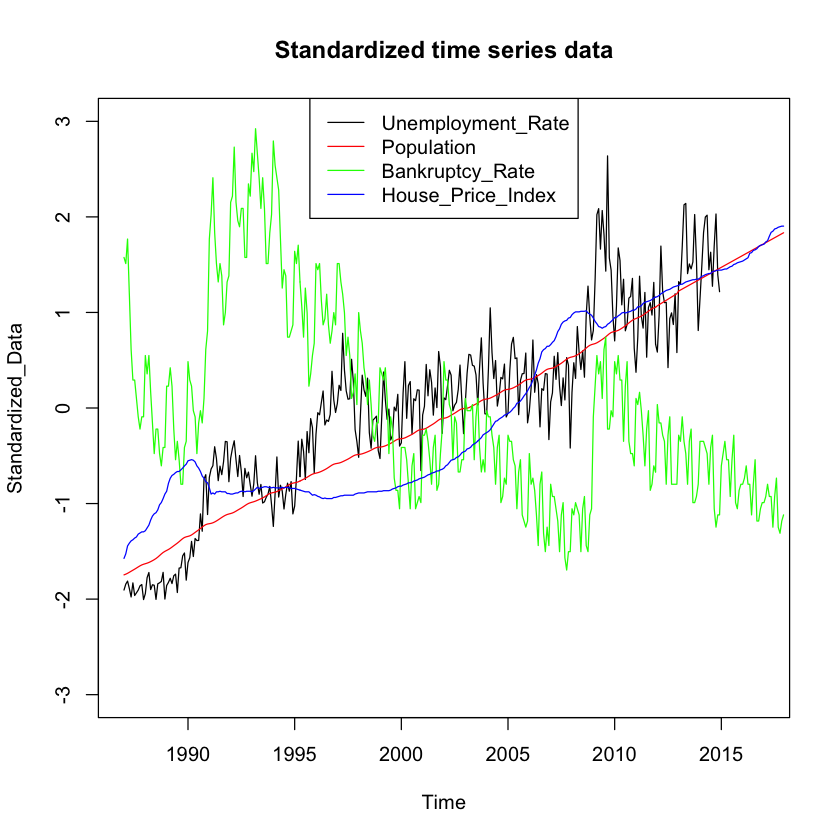

In [34]:
Standardized_Data=(Bankruptcy_Rate_full-mean(Bankruptcy_Rate_full))/sd(Bankruptcy_Rate_full)
plot(Standardized_Data, ylim = c(-3, 3), xlim = c(1987, 2017),
     main="Standardized time series data",col="black")
#axis(1, xaxp=c(1986, 2017, 31), las=2)
#abline(v = 2013, lty = 3)

lines((Population-mean(Population))/sd(Population), 
       ylim = c(-3, 3), col="red")

lines((Unemployment_Rate-mean(Unemployment_Rate))/sd(Unemployment_Rate), ylim = c(-3, 3), col="green")

lines((House_Price_Index-mean(House_Price_Index))/sd(House_Price_Index), 
       ylim = c(-3, 3), col="blue")

legend("top", legend = c("Unemployment_Rate", "Population", "Bankruptcy_Rate", "House_Price_Index"), 
       lty = 1, col = c("black", "red","green", "blue"))

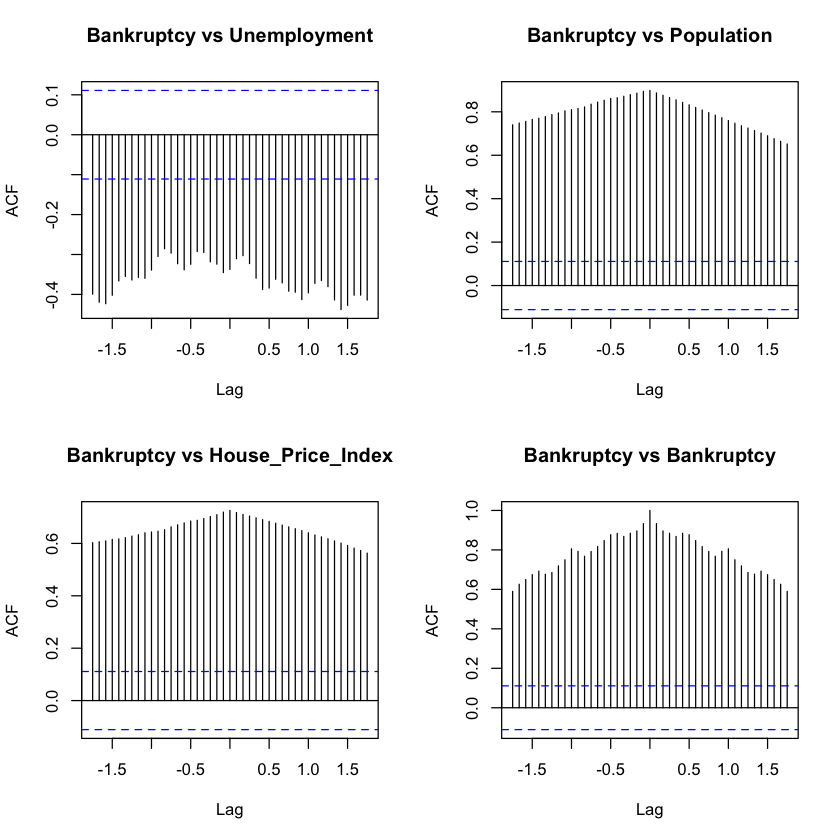

In [19]:
par(mfrow=c(2,2))
ccf(Bankruptcy_Rate_train, Unemployment_Rate_train, main="Bankruptcy vs Unemployment")
ccf(Bankruptcy_Rate_train, Population_train,  main="Bankruptcy vs Population")
ccf(Bankruptcy_Rate_train, House_Price_Index_train, main="Bankruptcy vs House_Price_Index")
ccf(Bankruptcy_Rate_train, Bankruptcy_Rate_train, main="Bankruptcy vs Bankruptcy")

%%%%%%%<br>
SARIMAX<br>
%%%%%%%

In [20]:
(lam <- BoxCox.lambda(Bankruptcy_Rate_train))

[1] 0.218485

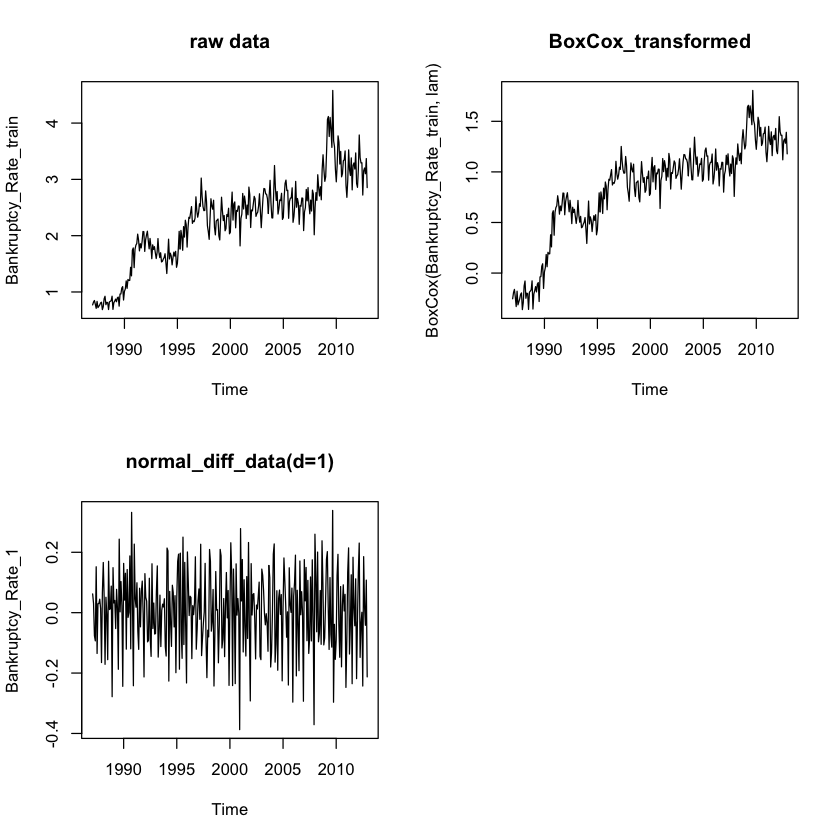

In [21]:
par(mfrow=c(2,2))
plot(Bankruptcy_Rate_train, main = "raw data")
plot(BoxCox(Bankruptcy_Rate_train,lam), main = "BoxCox_transformed")

Bankruptcy_Rate_1 <- diff(BoxCox(Bankruptcy_Rate_train,lam))
plot(Bankruptcy_Rate_1, main = "normal_diff_data(d=1)")

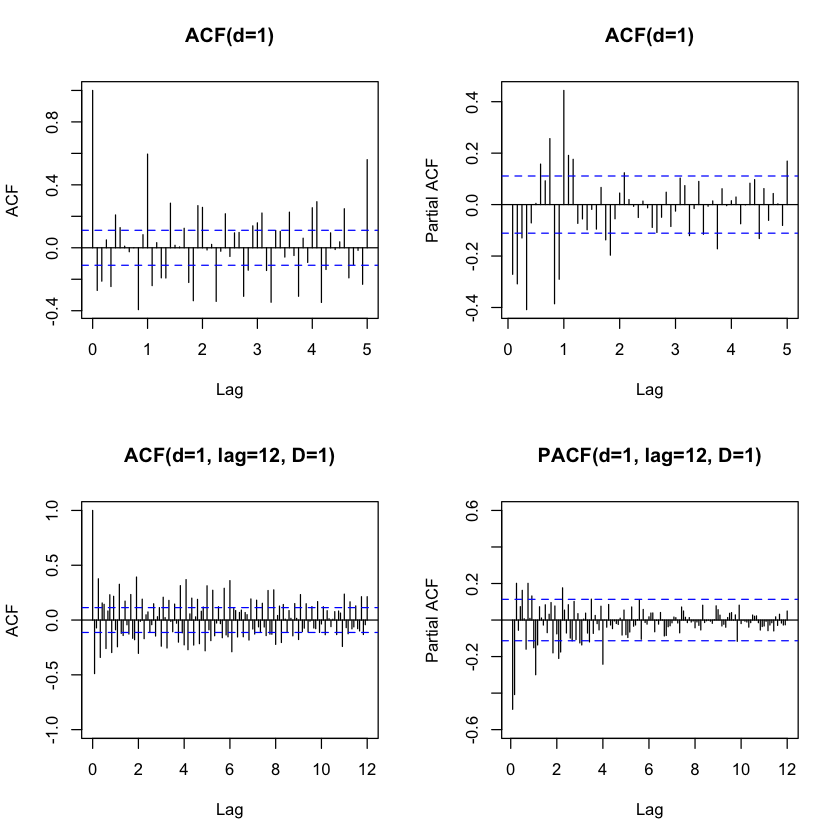

In [22]:
par(mfrow=c(2,2))
acf(Bankruptcy_Rate_1, main = "ACF(d=1)", lag.max = 60)
pacf(Bankruptcy_Rate_1, main = "ACF(d=1)", lag.max = 60)
#acf(diff(Bankruptcy_Rate_1, lag=6), main = "ACF(d=1, lag=6, D=1)", lag.max = 60,ylim=range(-1,1))
#pacf(diff(Bankruptcy_Rate_1, lag=6), main = "PACF(d=1, lag=6, D=1)", lag.max = 60,ylim=range(-0.6,0.6))
acf(diff(Bankruptcy_Rate_1, lag=12), main = "ACF(d=1, lag=12, D=1)", lag.max = 144,ylim=range(-1,1))
pacf(diff(Bankruptcy_Rate_1, lag=12), main = "PACF(d=1, lag=12, D=1)", lag.max = 144,ylim=range(-0.6,0.6))

In [23]:
RMSE_ini=1
para=c()
i=1
for (p in c(1,2,3,4)){
  for (q in c(1,2,3,4)){
      for (P in c(1,2,3,4,5,6)){
          for (Q in c(1,2,3,4,5,6)){
            tryCatch({  
            m <- Arima(Bankruptcy_Rate_train, method="CSS",order = c(p,1,q), 
                        seasonal = list(order = c(P,1,Q), period = 12), lambda=lam)  
            f.arima <- forecast(m) 
                
            rmse.arima <- sqrt(mean((f.arima$mean- Bankruptcy_Rate_validation)^2))    
            if (rmse.arima<RMSE_ini){
                print(paste("p =",p,"q =",q,"P =",P,"Q =",Q, "RMSE =", rmse.arima))
                RMSE_ini=rmse.arima
            }
                },
            error = function(e){
            cat("Error:", conditionMessage(e),"\n") }
            )
              para$RMSE[i]=rmse.arima
              para$p[i]=p
              para$q[i]=q
              para$P[i]=P
              para$Q[i]=Q
            i=i+1
}   }   } }

[1] "p = 1 q = 1 P = 1 Q = 1 RMSE = 0.502819588911884"
[1] "p = 1 q = 1 P = 1 Q = 2 RMSE = 0.499937291200737"
[1] "p = 1 q = 1 P = 1 Q = 3 RMSE = 0.498989009352117"
[1] "p = 1 q = 1 P = 1 Q = 4 RMSE = 0.424799171196995"
[1] "p = 1 q = 1 P = 1 Q = 5 RMSE = 0.338659819852732"
[1] "p = 1 q = 1 P = 1 Q = 6 RMSE = 0.31436608533308"
[1] "p = 1 q = 1 P = 2 Q = 2 RMSE = 0.271480214447376"
[1] "p = 1 q = 1 P = 2 Q = 3 RMSE = 0.261068985997049"
[1] "p = 1 q = 1 P = 3 Q = 1 RMSE = 0.244060216631757"


In [24]:
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p,q,P,Q
13,0.2440602,1,1,3,1
553,0.2532280,4,4,3,1
225,0.2550543,2,3,2,3
261,0.2551676,2,4,2,3
189,0.2553588,2,2,2,3
226,0.2560221,2,3,2,4
262,0.2571636,2,4,2,4
190,0.2573906,2,2,2,4
518,0.2583737,4,3,3,2
513,0.2594079,4,3,2,3


In [25]:
RMSE_ini=1
para=c()
i=1
for (p in c(1,2,3,4)){
  for (q in c(1,2,3,4)){
      for (P in c(1,2,3,4,5,6)){
          for (Q in c(1,2,3,4,5,6)){
            tryCatch({  
            m <- Arima(Bankruptcy_Rate_train, method="CSS",order = c(p,1,q), 
                       xreg = data.frame(Unemployment_Rate = Unemployment_Rate_train ),
                       #,House_Price_Index = House_Price_Index_train
                                        # Population = Population_train ),
                        seasonal = list(order = c(P,1,Q), period = 12), lambda=lam)  
            f.arima <- forecast(m, xreg = data.frame(Unemployment_Rate = Unemployment_Rate_validation )) 
                #,House_Price_Index = House_Price_Index_validation
                                                    # Population = Population_validation))
            rmse.arima <- sqrt(mean((f.arima$mean- Bankruptcy_Rate_validation)^2))    
            if (rmse.arima<RMSE_ini){
                print(paste("p =",p,"q =",q,"P =",P,"Q =",Q, "RMSE =", rmse.arima))
                RMSE_ini=rmse.arima
            }
                },
            error = function(e){
            cat("Error:", conditionMessage(e),"\n") }
            )
              para$RMSE[i]=rmse.arima
              para$p[i]=p
              para$q[i]=q
              para$P[i]=P
              para$Q[i]=Q
            i=i+1
}   }   } }

[1] "p = 1 q = 1 P = 1 Q = 1 RMSE = 0.525063769188445"
[1] "p = 1 q = 1 P = 1 Q = 2 RMSE = 0.51478343302911"
[1] "p = 1 q = 1 P = 1 Q = 3 RMSE = 0.514184666282557"
[1] "p = 1 q = 1 P = 1 Q = 4 RMSE = 0.468313975669343"
[1] "p = 1 q = 1 P = 1 Q = 5 RMSE = 0.338534917239411"
[1] "p = 1 q = 1 P = 1 Q = 6 RMSE = 0.311141713889574"
[1] "p = 1 q = 1 P = 2 Q = 2 RMSE = 0.290153668160086"
[1] "p = 1 q = 1 P = 2 Q = 3 RMSE = 0.25911983236023"
[1] "p = 1 q = 2 P = 2 Q = 3 RMSE = 0.258582483038714"
[1] "p = 1 q = 2 P = 3 Q = 2 RMSE = 0.256872210317546"
[1] "p = 1 q = 2 P = 3 Q = 3 RMSE = 0.256718673057483"
[1] "p = 3 q = 3 P = 4 Q = 5 RMSE = 0.245743074639729"


In [39]:
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p,q,P,Q
383,0.2457431,3,3,4,5
51,0.2567187,1,2,3,3
50,0.2568722,1,2,3,2
226,0.2576824,2,3,2,4
45,0.2585825,1,2,2,3
9,0.2591198,1,1,2,3
405,0.2592321,3,4,2,3
46,0.2593030,1,2,2,4
10,0.2596236,1,1,2,4
117,0.2601200,1,4,2,3


In [ ]:
ts(c(Bankruptcy_Rate,Bankruptcy_Rate_validation), start = c(1987, 1), frequency = 12) 

In [379]:
RMSE_test=c()
pred_esemble=rep(0,length(test$Bankruptcy_Rate))
for (i in c(1:10)){
m <- Arima(ts(c(Bankruptcy_Rate_train,Bankruptcy_Rate_validation), start = c(1987, 1), frequency = 12),
           method="CSS",order = c(para_sorted$p[i],1,para_sorted$q[i]), 
           seasonal = list(order = c(para_sorted$P[i],1,para_sorted$Q[i]), period = 12), lambda=lam,
           xreg = data.frame(House_Price_Index = c(House_Price_Index, validation$House_Price_Index)))  

f.arima <- forecast(m, h = 36,xreg = data.frame(House_Price_Index = test$House_Price_Index))
pred_esemble=pred_esemble+f.arima$mean
RMSE_test[i]=sqrt(mean((f.arima$mean- test$Bankruptcy_Rate)^2)) 
    }

In [380]:
RMSE_test

[1] 0.3892024 0.3147045 0.3354472 0.4979015 0.3733017 0.3282353 0.3176318
 [8] 0.3183824 0.3209817 0.3882433

In [381]:
pred_esemble=pred_esemble/10
sqrt(mean((pred_esemble- test$Bankruptcy_Rate)^2)) 

[1] 0.3286377

# p = 4 q = 6 P = 2 Q = 1

Series: Bankruptcy_Rate 
ARIMA(4,1,6)(2,1,1)[12] 
Box Cox transformation: lambda= 0.2165363 

Coefficients:
          ar1      ar2      ar3      ar4     ma1     ma2     ma3     ma4
      -1.2638  -1.1630  -1.2828  -0.7208  0.6796  0.6079  1.0760  0.1583
s.e.   0.0180   0.0167   0.0127   0.0163  0.0305     NaN  0.0617  0.0622
         ma5     ma6    sar1     sar2     sma1
      -0.091  0.3053  0.2886  -0.3610  -0.8215
s.e.     NaN  0.0237  0.0359   0.0588   0.0324

sigma^2 estimated as 0.005239:  part log likelihood=323.77

[1] 0.5039871

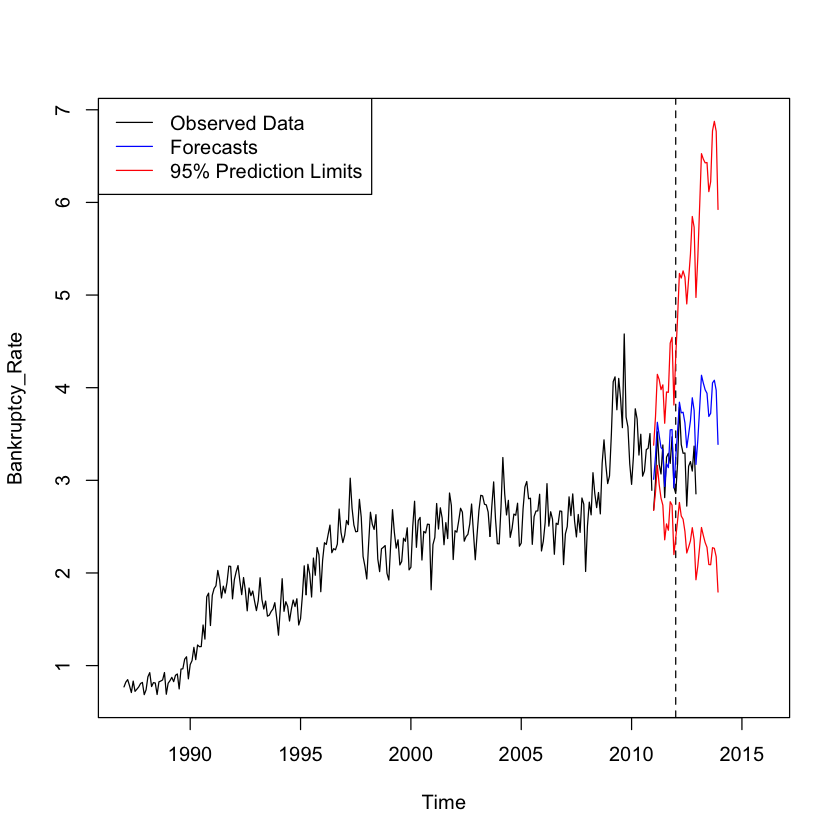

In [292]:
m <- Arima(Bankruptcy_Rate, method="CSS",order = c(4,1,6), 
           seasonal = list(order = c(2,1,1), period = 12), lambda=lam)
m
f.arima <- forecast(m, h = 36)
plot(Bankruptcy_Rate, xlim = c(1987, 2016),
     ylim = c(min(Bankruptcy_Rate, f.arima$lower[,2]), 
     max(Bankruptcy_Rate_validation, f.arima$upper[,2])) )
abline(v = 2012, lty = 2)
lines(Bankruptcy_Rate_validation)
lines(f.arima$mean, col = "blue")
lines(f.arima$lower[,2], col = "red")
lines(f.arima$upper[,2], col = "red")
legend("topleft", legend = c("Observed Data", "Forecasts", "95% Prediction Limits"), 
       lty = 1, col = c("black", "blue", "red"))


rmse.arima <- sqrt(mean((f.arima$mean- validation$Bankruptcy_Rate)^2))
rmse.arima

Series: Bankruptcy_Rate 
Regression with ARIMA(4,1,6)(2,1,1)[12] errors 
Box Cox transformation: lambda= 0.2165363 

Coefficients:
          ar1     ar2     ar3     ar4     ma1      ma2     ma3      ma4     ma5
      -1.0178  -0.059  1.0354  0.7714  0.2949  -0.5854  -0.761  -0.0038  0.4605
s.e.   0.0672   0.041  0.0398  0.0637  0.0858   0.0656   0.078   0.0865  0.0730
          ma6     sar1     sar2     sma1  House_Price_Index
      -0.1201  -0.0302  -0.2141  -0.6915            -0.0609
s.e.   0.0745   0.0849   0.0669   0.0654             0.0081

sigma^2 estimated as 0.005059:  part log likelihood=329.11

[1] 0.2071169

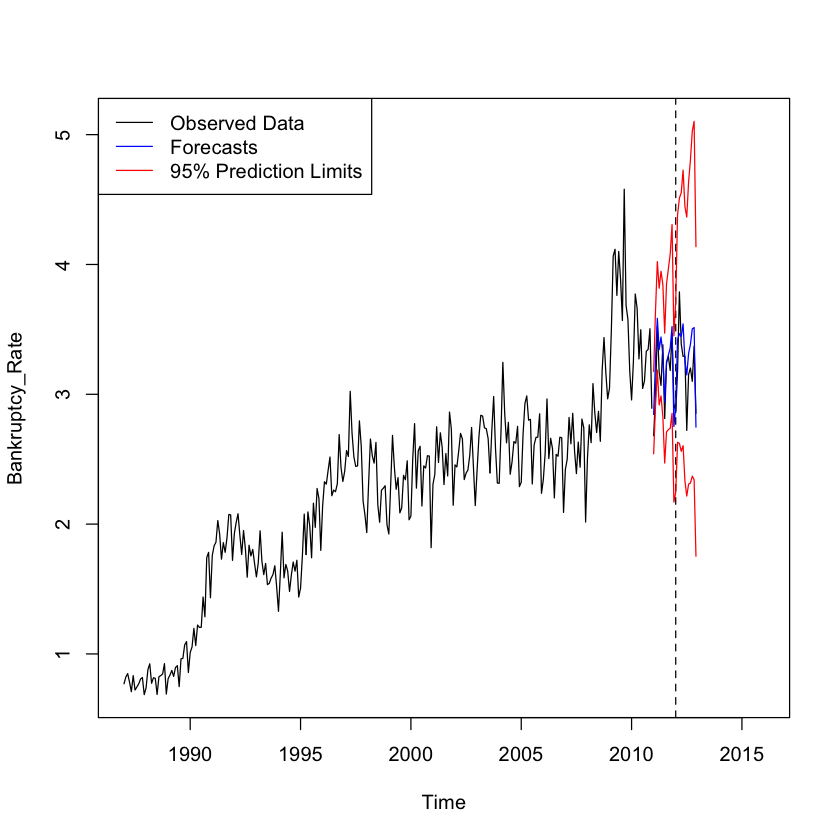

In [291]:
#par(mfrow=c(2,2))
m <- Arima(Bankruptcy_Rate, method="CSS",order = c(4,1,6), xreg = data.frame(House_Price_Index),
            seasonal = list(order = c(2,1,1), period = 12), lambda=lam)
m
f.arima <- forecast(m, h = 36,xreg = data.frame(House_Price_Index = validation$House_Price_Index))
plot(Bankruptcy_Rate, xlim = c(1987, 2016),
     ylim = c(min(Bankruptcy_Rate, f.arima$lower[,2]), 
     max(Bankruptcy_Rate_validation, f.arima$upper[,2])) )
abline(v = 2012, lty = 2)
lines(Bankruptcy_Rate_validation)
lines(f.arima$mean, col = "blue")
lines(f.arima$lower[,2], col = "red")
lines(f.arima$upper[,2], col = "red")
legend("topleft", legend = c("Observed Data", "Forecasts", "95% Prediction Limits"), 
       lty = 1, col = c("black", "blue", "red"))
rmse.arima <- sqrt(mean((f.arima$mean- validation$Bankruptcy_Rate)^2))
rmse.arima

%%%%%%%%%<br>
VAR models<br>
%%%%%%%%%

In [77]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                Unemployment_Rate = Unemployment_Rate_train,
                                House_Price_Index = House_Price_Index_train,
                                Population = Population_train), p = p)
    pred <- predict(m.var, n.ahead = 24, ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
1,0.3350171,1
2,0.3375662,2
16,0.3432215,16
13,0.3569751,13
19,0.3575223,19
3,0.3587613,3
15,0.3636319,15
17,0.3666759,17
4,0.3675982,4
14,0.3709291,14


In [78]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                Unemployment_Rate = Unemployment_Rate_train,
                                Population = Population_train), p = p)
    pred <- predict(m.var, n.ahead = 24, ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
1,0.3227050,1
2,0.3611522,2
16,0.3638036,16
17,0.3738582,17
19,0.3784964,19
15,0.3949801,15
14,0.4076400,14
3,0.4077919,3
18,0.4247003,18
20,0.4353570,20


In [79]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                House_Price_Index = House_Price_Index_train,
                                Population = Population_train), p = p)
    pred <- predict(m.var, n.ahead = 24, ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
16,0.3377829,16
15,0.3409405,15
14,0.3414454,14
17,0.3464406,17
13,0.3492545,13
2,0.3505849,2
8,0.3550640,8
9,0.3557383,9
12,0.3592811,12
4,0.3592927,4


In [80]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                Population = Population_train), p = p)
    pred <- predict(m.var, n.ahead = 24, ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
1,0.3441766,1
16,0.3529190,16
17,0.3585800,17
2,0.3712718,2
14,0.3767575,14
15,0.3779577,15
19,0.3814130,19
18,0.4099984,18
3,0.4173886,3
20,0.4207581,20


In [81]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                House_Price_Index = House_Price_Index_train), p = p)
    pred <- predict(m.var, n.ahead = 24, ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
12,0.3867549,12
13,0.4064110,13
11,0.4164866,11
14,0.4402417,14
6,0.4436175,6
19,0.4449717,19
7,0.4492940,7
8,0.4498963,8
20,0.4504654,20
18,0.4515815,18


In [82]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                Unemployment_Rate = Unemployment_Rate_train), p = p)
    pred <- predict(m.var, n.ahead = 24, ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
12,0.5987747,12
20,0.6069838,20
9,0.6138016,9
21,0.6157152,21
18,0.6204815,18
6,0.6222478,6
19,0.6235219,19
13,0.6239852,13
11,0.6242606,11
5,0.6269727,5


%%%%%%%%%<br>
# VARX models<br>
%%%%%%%%%

In [94]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                Unemployment_Rate = Unemployment_Rate_train,
                                House_Price_Index = House_Price_Index_train),
                 exogen = data.frame(Population = Population_train), p = p)
    pred <- predict(m.var, n.ahead = 24, dumvar = data.frame(Population = Population_validation), ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
25,0.2713840,25
22,0.2740723,22
21,0.2827053,21
20,0.2881977,20
23,0.2901132,23
19,0.2901473,19
24,0.2911832,24
18,0.2973289,18
15,0.3020075,15
16,0.3046809,16


In [95]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                Population = Population_train,
                                House_Price_Index = House_Price_Index_train),
                 exogen = data.frame(Unemployment_Rate = Unemployment_Rate_train), p = p)
    pred <- predict(m.var, n.ahead = 24, dumvar = data.frame(Unemployment_Rate = Unemployment_Rate_validation), ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
12,0.3655547,12
13,0.3759584,13
19,0.3808679,19
18,0.3909498,18
20,0.3933513,20
11,0.3946956,11
14,0.3993402,14
22,0.4043966,22
23,0.4060324,23
21,0.4075683,21


In [91]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                Population = Population_train,
                                Unemployment_Rate = Unemployment_Rate_train),
                 exogen = data.frame(House_Price_Index = House_Price_Index_train), p = p)
    pred <- predict(m.var, n.ahead = 24, dumvar = data.frame(House_Price_Index = House_Price_Index_validation), ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
1,0.3321495,1
16,0.3357921,16
17,0.3461771,17
14,0.3596468,14
2,0.3619102,2
15,0.3704735,15
19,0.3759430,19
13,0.3956141,13
3,0.4019354,3
18,0.4034913,18


In [92]:
RMSE_ini=1
para=c()
i=1
for (p in c(1:25))
{
    m.var <- VAR(y = data.frame(Bankruptcy_Rate = Bankruptcy_Rate_train, 
                                Unemployment_Rate = Unemployment_Rate_train),
                 exogen = data.frame(House_Price_Index = House_Price_Index_train,
                                     Population = Population_train), p = p)
    pred <- predict(m.var, n.ahead = 24, dumvar = data.frame(House_Price_Index = House_Price_Index_validation,
                                                             Population = Population_validation), ci = 0.95)
    #plot(pred)
    rmse.var <- sqrt(mean((pred$fcst$Bankruptcy_Rate[,1] - Bankruptcy_Rate_validation)^2))
    para$RMSE[i]=rmse.var
    para$p[i]=p
    i=i+1
    }
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p
25,0.2964984,25
22,0.3033436,22
21,0.3040430,21
15,0.3195849,15
20,0.3200948,20
16,0.3212774,16
24,0.3213581,24
19,0.3233244,19
1,0.3249746,1
17,0.3257862,17


# making prediction

In [26]:
test <- read.csv("test.csv", header=T)
Population_test <- ts(test$Population, start = c(2015, 1), frequency = 12)
House_Price_Index_test <- ts(test$House_Price_Index, start = c(2015, 1), frequency = 12)
Unemployment_Rate_test <- ts(test$Unemployment_Rate, start = c(2015, 1), frequency = 12)
Population_test

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
2015 35903714 35934762 35965810 35996857 36027905 36058952 36090000 36121048
2016 36276286 36307333 36338381 36369429 36400476 36431524 36462571 36493619
2017 36648857 36679905 36710952 36742000 36773048 36804095 36835143 36866190
          Sep      Oct      Nov      Dec
2015 36152095 36183143 36214190 36245238
2016 36524667 36555714 36586762 36617810
2017 36897238 36928286 36959333 36990381

In [27]:
RMSE_ini=1
para=c()
i=1
for (p in c(1,2,3,4)){
  for (q in c(1,2,3,4)){
      for (P in c(1,2,3,4,5,6)){
          for (Q in c(1,2,3,4,5,6)){
            tryCatch({  
           m <- Arima(Bankruptcy_Rate_train, method="CSS",order = c(p,1,q), 
                       xreg = data.frame(Unemployment_Rate = Unemployment_Rate_train,
                       House_Price_Index = House_Price_Index_train,
                       Population = Population_train ),
                        seasonal = list(order = c(P,1,Q), period = 12), lambda=lam)  
            f.arima <- forecast(m, xreg = data.frame(Unemployment_Rate = Unemployment_Rate_validation,
                                                     House_Price_Index = House_Price_Index_validation,
                                                     Population = Population_validation))
            rmse.arima <- sqrt(mean((f.arima$mean- Bankruptcy_Rate_validation)^2))    
            if (rmse.arima<RMSE_ini){
                print(paste("p =",p,"q =",q,"P =",P,"Q =",Q, "RMSE =", rmse.arima))
                RMSE_ini=rmse.arima
            }
                },
            error = function(e){
            cat("Error:", conditionMessage(e),"\n") }
            )
              para$RMSE[i]=rmse.arima
              para$p[i]=p
              para$q[i]=q
              para$P[i]=P
              para$Q[i]=Q
            i=i+1
}   }   } }

[1] "p = 1 q = 1 P = 1 Q = 1 RMSE = 0.312066254572284"
[1] "p = 1 q = 1 P = 1 Q = 2 RMSE = 0.284535249105209"
[1] "p = 1 q = 1 P = 1 Q = 3 RMSE = 0.284214120425579"
[1] "p = 1 q = 1 P = 1 Q = 4 RMSE = 0.253788214282426"
[1] "p = 1 q = 1 P = 2 Q = 1 RMSE = 0.24082730297837"
[1] "p = 1 q = 1 P = 2 Q = 3 RMSE = 0.222057959627487"
[1] "p = 1 q = 2 P = 2 Q = 3 RMSE = 0.221397700127472"
[1] "p = 3 q = 3 P = 1 Q = 1 RMSE = 0.218168910758623"
[1] "p = 4 q = 2 P = 1 Q = 1 RMSE = 0.185478241674325"


In [28]:
para=data.frame(para)
para_sorted=para[order(para$RMSE)[1:10],]
para_sorted

,RMSE,p,q,P,Q
469,0.1854782,4,2,1,1
508,0.1946205,4,3,1,4
507,0.1971810,4,3,1,3
543,0.1986374,4,4,1,3
506,0.2014739,4,3,1,2
542,0.2022304,4,4,1,2
544,0.2157575,4,4,1,4
361,0.2181689,3,3,1,1
45,0.2213977,1,2,2,3
9,0.2220580,1,1,2,3


In [88]:
pred_esemble_mean=c()
pred_esemble_upper=c()
pred_esemble_lower=c()
pred=rep(0,36)
fit=rep(0,336)

for (i in c(1:10)){
m <- Arima(ts(c(Bankruptcy_Rate_train,Bankruptcy_Rate_validation), start = c(1987, 1), frequency = 12),
           method="CSS",order = c(para_sorted$p[i],1,para_sorted$q[i]), 
           seasonal = list(order = c(para_sorted$P[i],1,para_sorted$Q[i]), period = 12), lambda=lam,
           xreg = data.frame(Population = c(Population_train, Population_validation),
                             House_Price_Index = c(House_Price_Index_train, House_Price_Index_validation),
                            Unemployment_Rate = c(Unemployment_Rate_train, Unemployment_Rate_validation)))  

f.arima <- forecast(m, h = 36,xreg = data.frame(Population = Population_test,
                                     House_Price_Index = House_Price_Index_test,
                                     Unemployment_Rate = Unemployment_Rate_test))
    pred_esemble_mean=cbind(pred_esemble_mean, f.arima$mean)
    pred_esemble_upper=cbind(pred_esemble_upper, f.arima$upper[,2])
    pred_esemble_lower=cbind(pred_esemble_lower, f.arima$lower[,2])
    
    pred=pred+f.arima$mean
    fit=fit+InvBoxCox(BoxCox(ts(c(Bankruptcy_Rate_train,Bankruptcy_Rate_validation), 
                    start = c(1987, 1), frequency = 12),lam) -m$residuals, lam)
    }

In [79]:
length(InvBoxCox(BoxCox(ts(c(Bankruptcy_Rate_train,Bankruptcy_Rate_validation), 
                    start = c(1987, 1), frequency = 12),lam) -m$residuals, lam))

[1] 336

In [89]:
pred=pred/10
fit=fit/10


In [94]:
(pred)

          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
2015 3.430843 3.702315 4.338366 4.195295 4.009026 4.039146 3.696450 3.633652
2016 3.515103 3.840874 4.472981 4.229171 4.046184 4.126285 3.617696 3.768985
2017 3.464237 3.850678 4.372102 4.070362 4.021870 3.934165 3.493560 3.720564
          Sep      Oct      Nov      Dec
2015 4.048908 3.989468 3.840308 3.512135
2016 4.037002 3.909863 3.941819 3.432087
2017 3.856334 3.860034 3.921622 3.342324

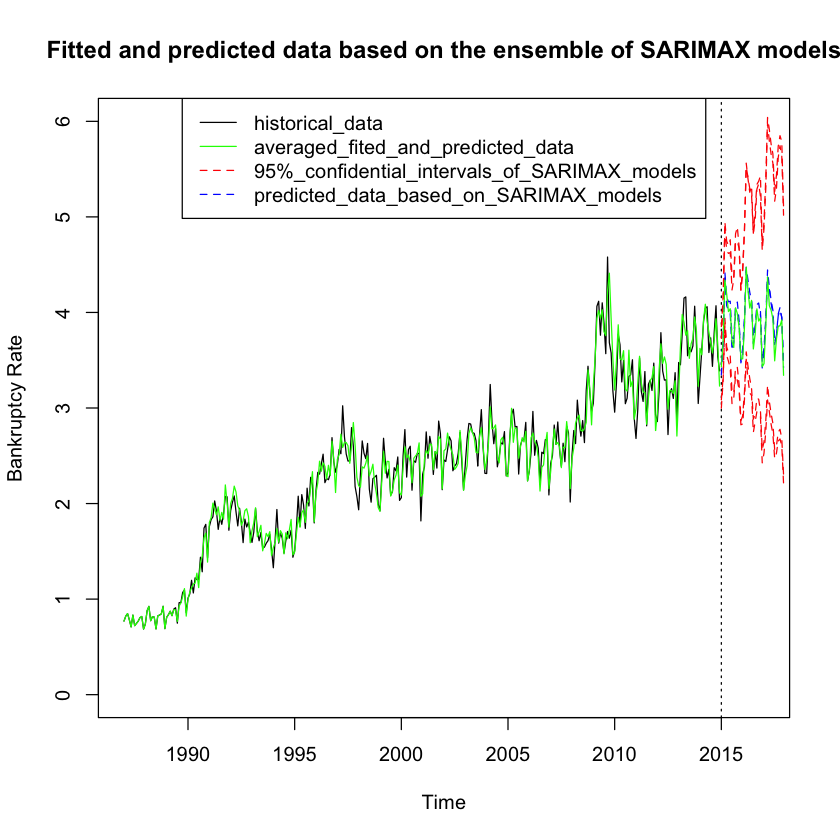

In [86]:
#Standardized_Data=(Unemployment_Rate_full-mean(Unemployment_Rate_full))/sd(Unemployment_Rate_full)
plot(Bankruptcy_Rate_full,xlim = c(1987, 2017), ylim = c(0, 6), 
     main="Fitted and predicted data based on the ensemble of SARIMAX models",
     ylab="Bankruptcy Rate", col="black")
abline(v = 2015, lty = 3)
color=c("red","green","blue","yellow","black")
for (i in c(1:2)){ 
    lines(pred_esemble_mean[,i], lty = 2,col="blue")
    lines(pred_esemble_upper[,i], lty = 2,col="red")
    lines(pred_esemble_lower[,i], lty = 2,col="red")
    }
lines(pred, lty = 1,col="green")
lines(fit, lty = 1,col="green")
legend("top", legend = c("historical_data", "averaged_fited_and_predicted_data", "95%_confidential_intervals_of_SARIMAX_models", "predicted_data_based_on_SARIMAX_models"), 
       lty = c(1,1,2,2), col = c("black", "green","red", "blue"))


In [51]:
color=c("red","green","blue","yellow","black")
color[7%%5]

[1] "green"